In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

In [3]:
format_plots()
#format_pizza_plots()

In [4]:
# Define the color map
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
## update data
def filter_df_long(df):
    max=62
    thresh=8
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    age_counts = df.index.get_level_values('age').value_counts()
    ages_greater = list(age_counts[age_counts > thresh].index)
    return df.loc[data.index.get_level_values('age').isin(ages_greater)]

In [6]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_v2_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df_long(data).groupby(['age','uuid','mouse']).mean()
data = data.query('age<100')
m_data = data[sorted(data.columns)].copy()

In [7]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_v2_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df_long(data).groupby(['age','uuid','mouse']).mean()
data = data.query('age<100')
f_data = data[sorted(data.columns)].copy()

In [8]:
# use only common ages
f_ages = f_data.index.get_level_values('age').unique().to_numpy()
m_ages = m_data.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
m_data = m_data.loc[m_data.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_data.loc[f_data.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)
data=pd.concat([m_data,f_data])

In [9]:
data

0         1   \
age       uuid                                 mouse sex                       
3.428571  0cac796a-edb5-4fba-95d2-12dc1bb8ef10 M3_02 m    0.038933  0.089067   
          0d173c85-9400-4d2f-8005-0b01f626b7c8 M4_04 m    0.025557  0.091354   
          13b21a14-233d-451d-9820-ea2f09abd034 M3_04 m    0.018208  0.098227   
          3ad71c75-8590-4bd2-9558-bb65df5e493a M1_01 m    0.067091  0.113614   
          3f9c1890-2bc6-4c0f-8605-d8e509358582 M1_03 m    0.051042  0.142708   
...                                                            ...       ...   
31.428572 cb77d7b7-b601-47c2-b3b5-2b6affcd966f F1_04 f    0.035000  0.070000   
          d55112c7-c4f6-4c37-9914-7624d16d8318 F1_02 f    0.041854  0.107623   
          d66ba20d-4753-4124-8d21-f85f7540b027 F5_02 f    0.027902  0.078226   
          d796782c-f3da-408b-89bc-a15bfd371663 F3_01 f    0.011460  0.079721   
          e3b1a8c4-6f58-4bdd-bc05-ef25ea71444f F5_04 f    0.010940  0.054202   

                                                                2         3   \
age       uuid                                 mouse sex                       
3.428571  0cac796a-edb5-4fba-95d2-12dc1bb8ef10 M3_02 m    0.030400  0.013867   
          0d173c85-9400-4d2f-8005-0b01f626b7c8 M4_04 m    0.019032  0.009244   
          13b21a14-233d-451d-9820-ea2f09abd034 M3_04 m    0.013896  0.025874   
          3ad71c75-8590-4bd2-9558-bb65df5e493a M1_01 m    0.067581  0.021058   
          3f9c1890-2bc6-4c0f-8605-d8e509358582 M1_03 m    0.043229  0.025000   
...                                                            ...       ...   
31.428572 cb77d7b7-b601-47c2-b3b5-2b6affcd966f F1_04 f    0.061818  0.035909   
          d55112c7-c4f6-4c37-9914-7624d16d8318 F1_02 f    0.058296  0.054808   
          d66ba20d-4753-4124-8d21-f85f7540b027 F5_02 f    0.046338  0.025411   
          d796782c-f3da-408b-89bc-a15bfd371663 F3_01 f    0.027404  0.030394   
          e3b1a8c4-6f58-4bdd-bc05-ef25ea71444f F5_04 f    0.021880  0.006464   

                                                                4         5   \
age       uuid                                 mouse sex                       
3.428571  0cac796a-edb5-4fba-95d2-12dc1bb8ef10 M3_02 m    0.023467  0.021333   
          0d173c85-9400-4d2f-8005-0b01f626b7c8 M4_04 m    0.022838  0.018488   
          13b21a14-233d-451d-9820-ea2f09abd034 M3_04 m    0.011500  0.034499   
          3ad71c75-8590-4bd2-9558-bb65df5e493a M1_01 m    0.024486  0.009305   
          3f9c1890-2bc6-4c0f-8605-d8e509358582 M1_03 m    0.007812  0.013021   
...                                                            ...       ...   
31.428572 cb77d7b7-b601-47c2-b3b5-2b6affcd966f F1_04 f    0.021818  0.032727   
          d55112c7-c4f6-4c37-9914-7624d16d8318 F1_02 f    0.019930  0.030892   
          d66ba20d-4753-4124-8d21-f85f7540b027 F5_02 f    0.022920  0.038864   
          d796782c-f3da-408b-89bc-a15bfd371663 F3_01 f    0.012456  0.070254   
          e3b1a8c4-6f58-4bdd-bc05-ef25ea71444f F5_04 f    0.015912  0.077076   

                                                                6         7   \
age       uuid                                 mouse sex                       
3.428571  0cac796a-edb5-4fba-95d2-12dc1bb8ef10 M3_02 m    0.020267  0.030933   
          0d173c85-9400-4d2f-8005-0b01f626b7c8 M4_04 m    0.010875  0.045677   
          13b21a14-233d-451d-9820-ea2f09abd034 M3_04 m    0.020125  0.032103   
          3ad71c75-8590-4bd2-9558-bb65df5e493a M1_01 m    0.008815  0.016650   
          3f9c1890-2bc6-4c0f-8605-d8e509358582 M1_03 m    0.018229  0.036979   
...                                                            ...       ...   
31.428572 cb77d7b7-b601-47c2-b3b5-2b6affcd966f F1_04 f    0.015909  0.034545   
          d55112c7-c4f6-4c37-9914-7624d16d8318 F1_02 f    0.018435  0.052815   
          d66ba20d-4753-4124-8d21-f85f7540b027 F5_02 f    0.012456  0.060289   
          d796782c-f3da-408b-89bc-a15bfd371663 F3_01 f    0.0

ValueError: num must be an integer with 1 <= num <= 66, not 67

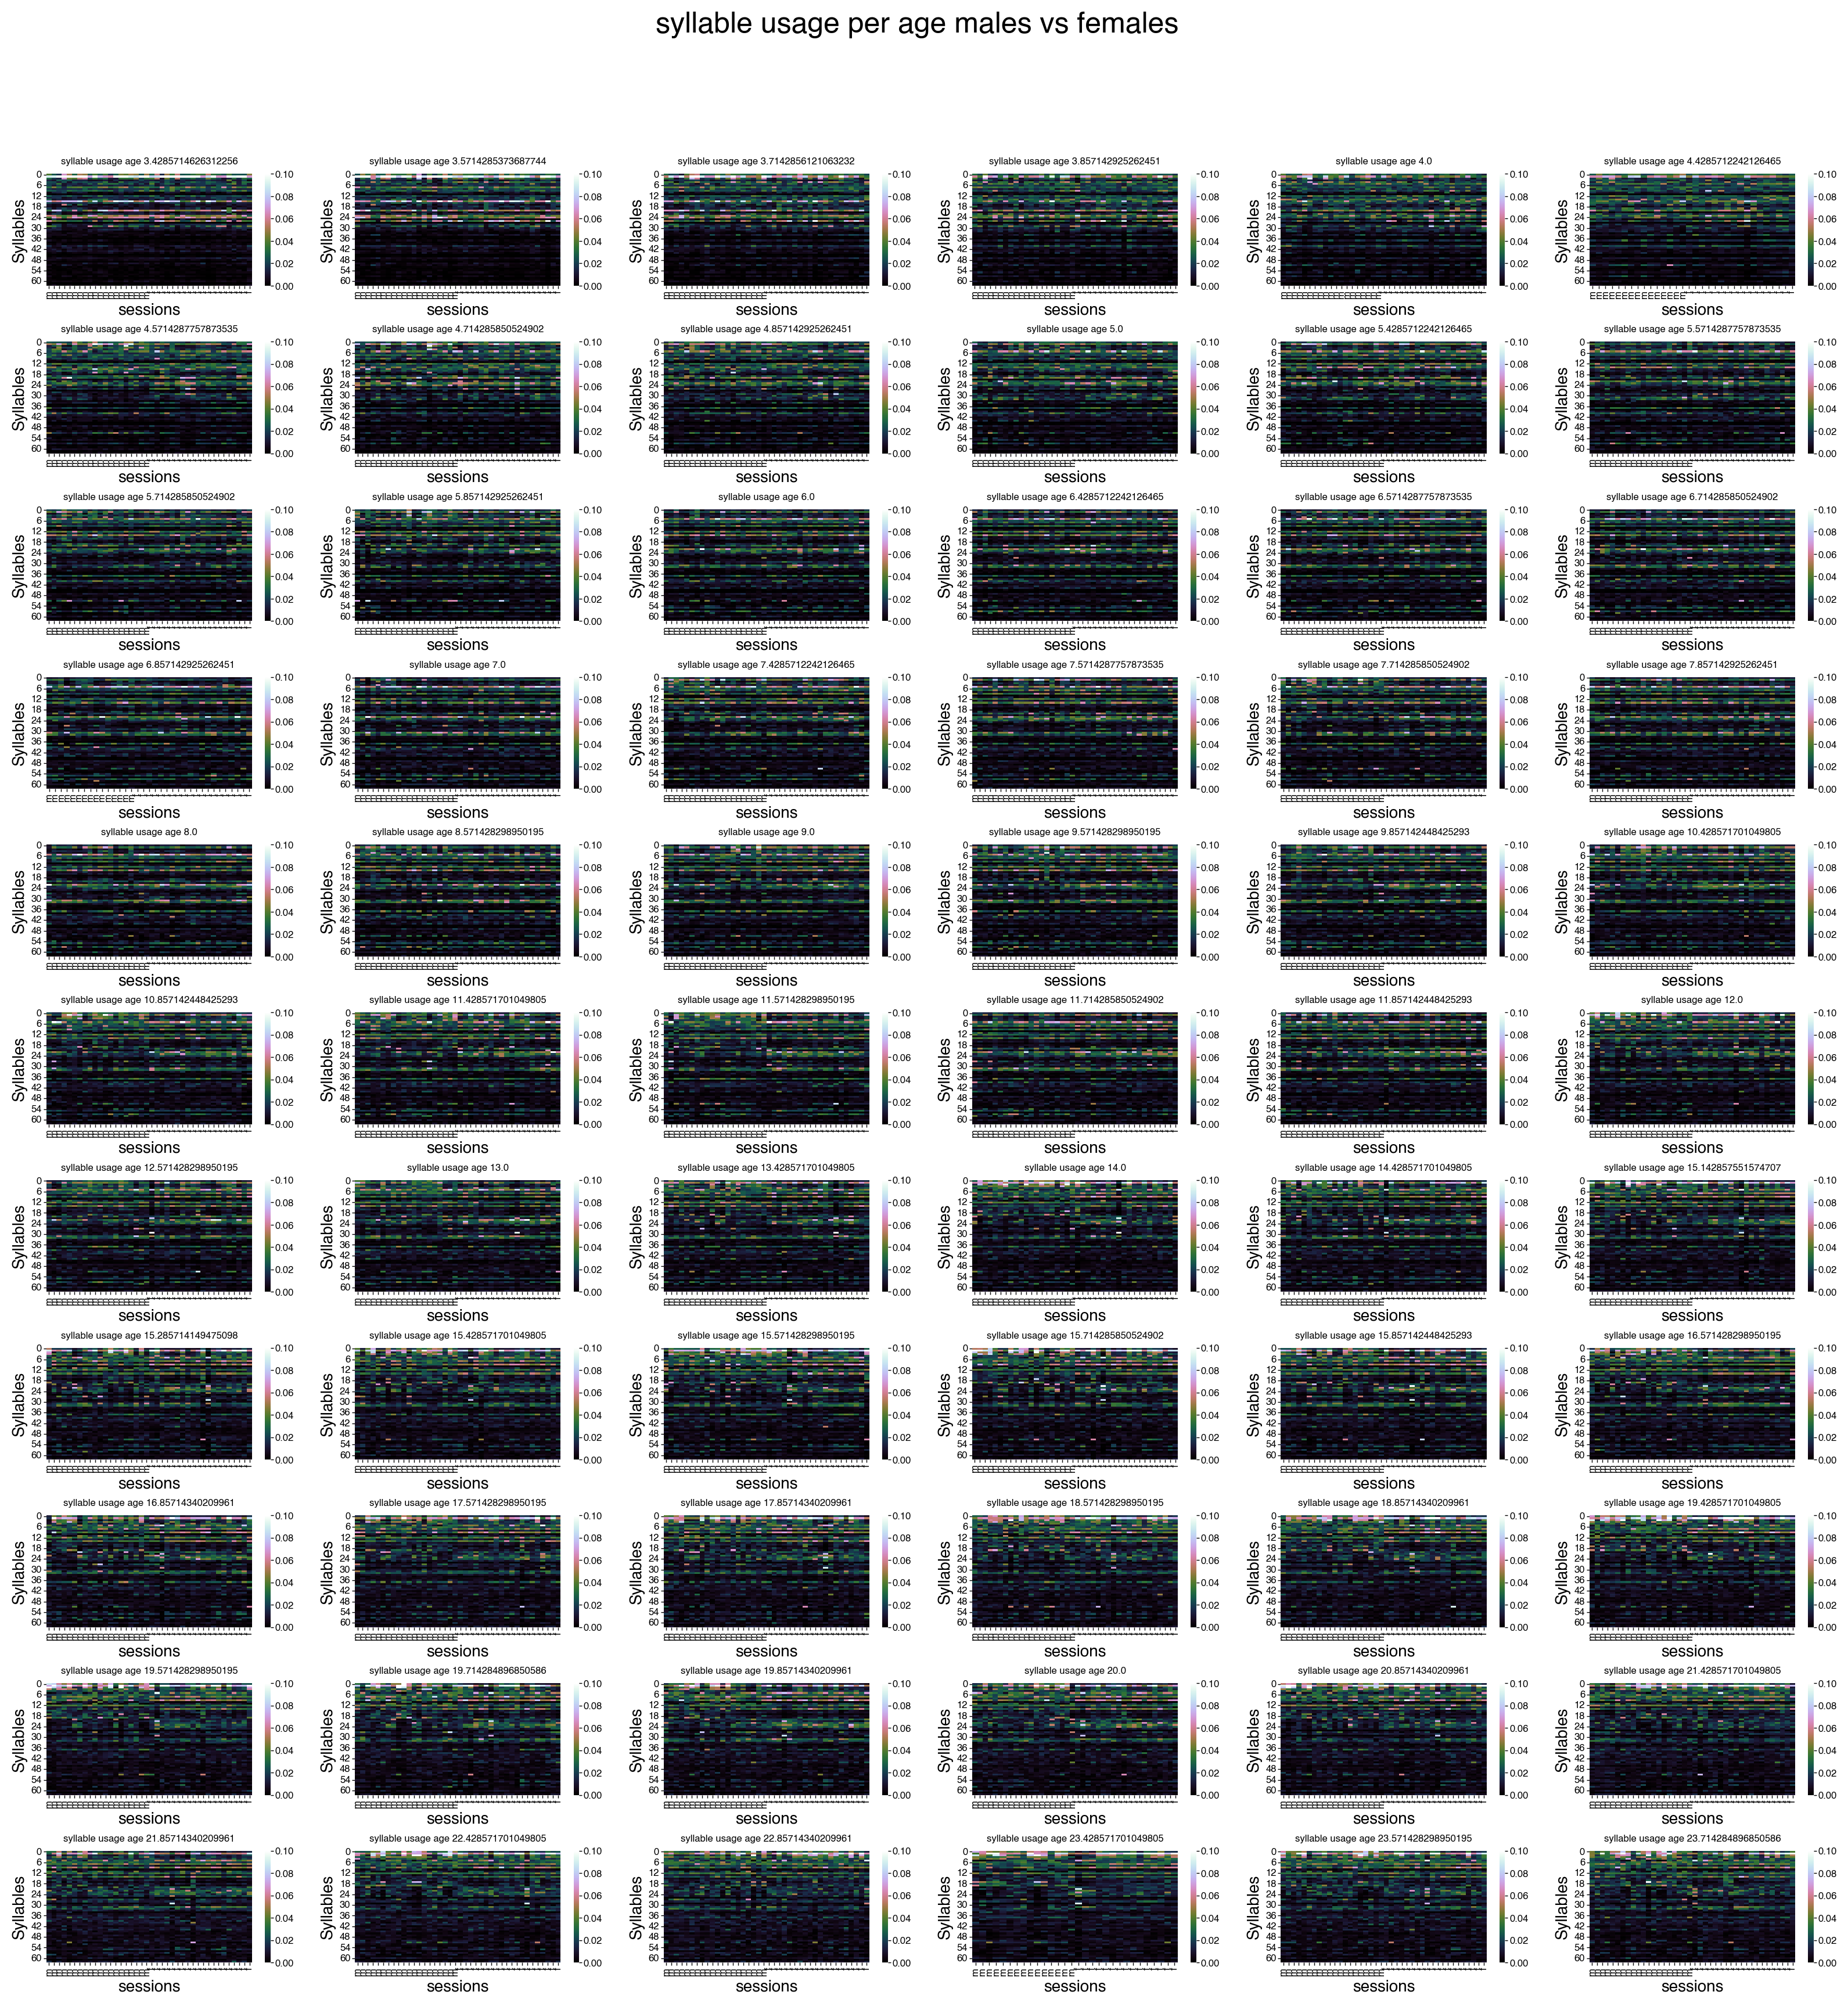

In [12]:
n=0
fig=plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("syllable usage per age males vs females", fontsize=18, y=0.95)
for age,_df in enumerate(data.groupby('age')):
    #ages.extend(_df[1].index.get_level_values('remapped_bins').to_numpy())
    x = _df[1]
    sex = _df[1].index.get_level_values('sex').to_numpy()
    ax = plt.subplot(11, 6, n + 1)
    sns.heatmap(x.T,cmap = 'cubehelix',vmax=0.1, xticklabels= sex)
    ax.set_title('syllable usage age ' + str(_df[0]))
    ax.set_ylabel('Syllables',fontsize=10)
    ax.set_xlabel('sessions',fontsize=10)
    n=n+1